### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import tensorflow as tf
tf.__version__

2024-06-10 13:11:23.819819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.13.1'

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import shutil

import warnings
warnings.filterwarnings('ignore')

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

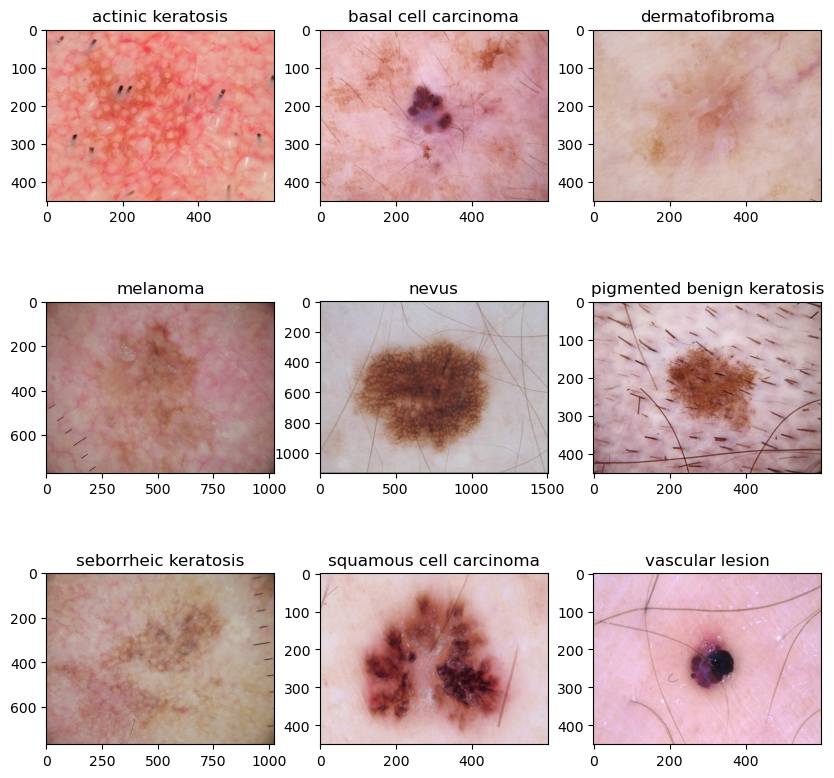

In [10]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
num_classes = 9

model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                   

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 111s 2s/step - loss: 2.0839 - accuracy: 0.1903 - val_loss: 2.0328 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 1729s 31s/step - loss: 2.0022 - accuracy: 0.2199 - val_loss: 1.9390 - val_accuracy: 0.3199
Epoch 3/20
56/56 [==============================] - 105s 2s/step - loss: 1.9367 - accuracy: 0.2600 - val_loss: 1.8452 - val_accuracy: 0.3266
Epoch 4/20
56/56 [==============================] - 1110s 20s/step - loss: 1.9503 - accuracy: 0.2785 - val_loss: 2.0342 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 505s 9s/step - loss: 2.0333 - accuracy: 0.1964 - val_loss: 2.0269 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 450s 8s/step - loss: 2.0240 - accuracy: 0.1987 - val_loss: 2.0294 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 104s 2s/step - loss: 2.0223 - accuracy: 0.2003 - val_loss: 2.0309 - val_accuracy: 0.2058
Epoch 8/2

### Visualizing training results

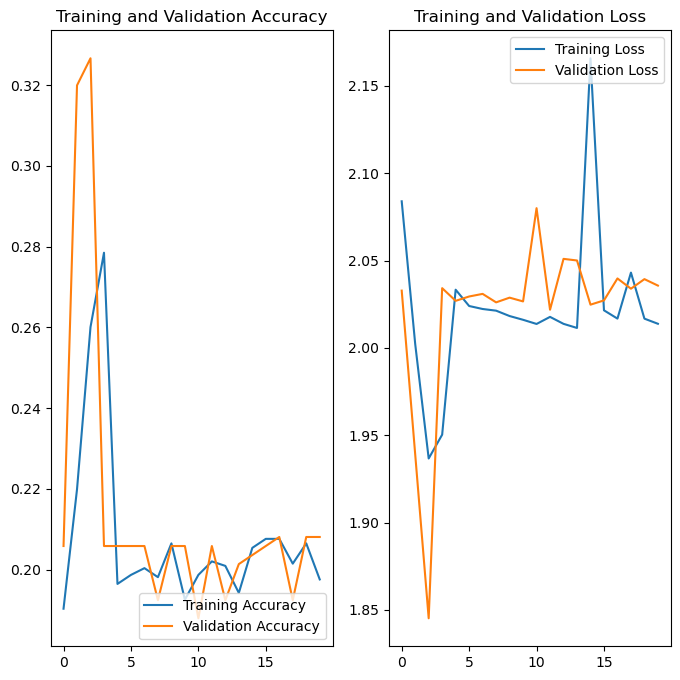

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

#### Finding on the first base model

#### . The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

#### . The accuracy is just around 75-80% because there are enough features to remember the pattern.

#### . But again, it's too early to comment on the overfitting & underfitting debate

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

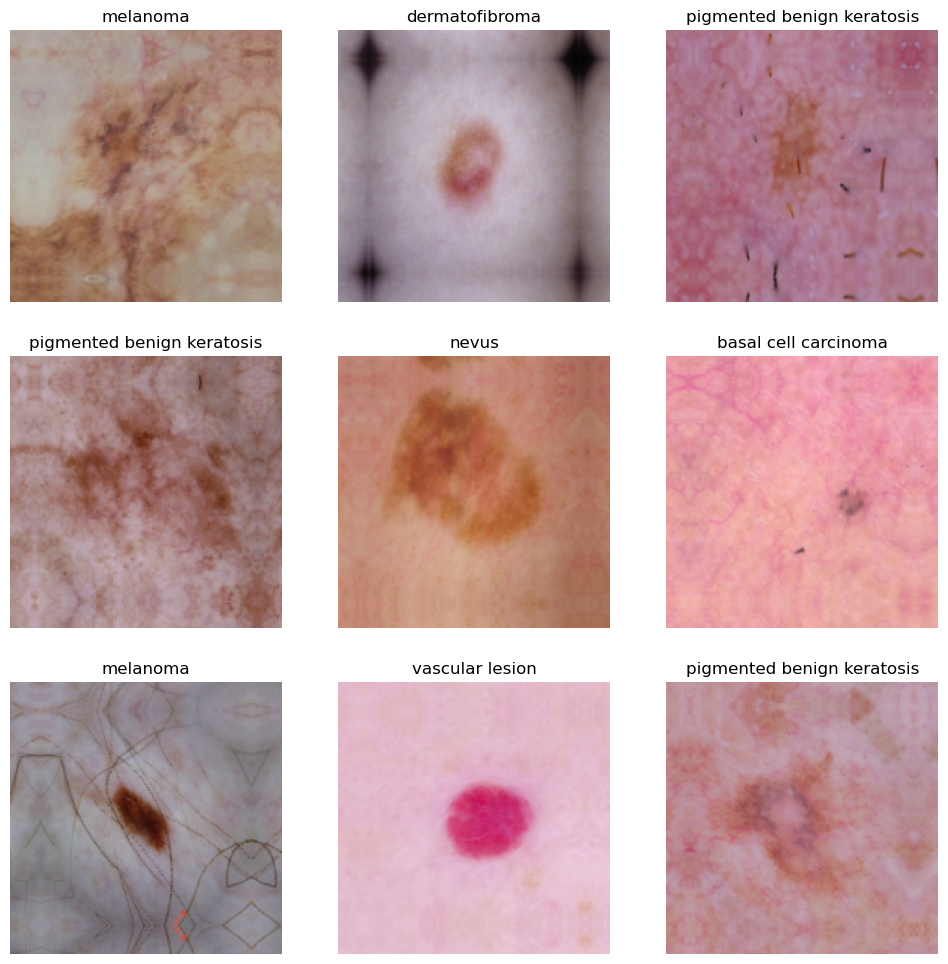

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Your code goes here
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [20]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 126s 2s/step - loss: 2.0747 - accuracy: 0.1842 - val_loss: 2.0388 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 132s 2s/step - loss: 2.0271 - accuracy: 0.1903 - val_loss: 2.0222 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 133s 2s/step - loss: 2.0286 - accuracy: 0.1970 - val_loss: 2.0278 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 193s 3s/step - loss: 2.0236 - accuracy: 0.2020 - val_loss: 2.0312 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 123s 2s/step - loss: 2.0087 - accuracy: 0.2026 - val_loss: 1.9608 - val_accuracy: 0.2506
Epoch 6/20
56/56 [==============================] - 128s 2s/step - loss: 2.1100 - accuracy: 0.2026 - val_loss: 2.0903 - val_accuracy: 0.1902
Epoch 7/20
56/56 [==============================] - 128s 2s/step - loss: 2.0343 - accuracy: 0.1936 - val_loss: 2.0171 - val_accuracy: 0.2103
Epoch 8/20
56

### Visualizing the results

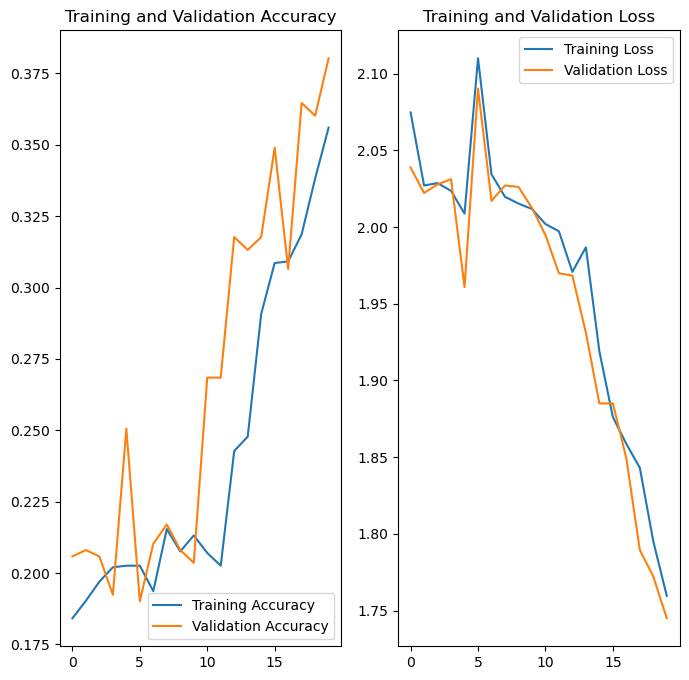

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Finding from Second Model

#### . There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

#### . We can increase the epochs to increase the accuracy so it's too early for judgement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2235,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2236,Skin cancer ISIC The International Skin Imagin...,vascular lesion
2237,Skin cancer ISIC The International Skin Imagin...,vascular lesion


<BarContainer object of 9 artists>

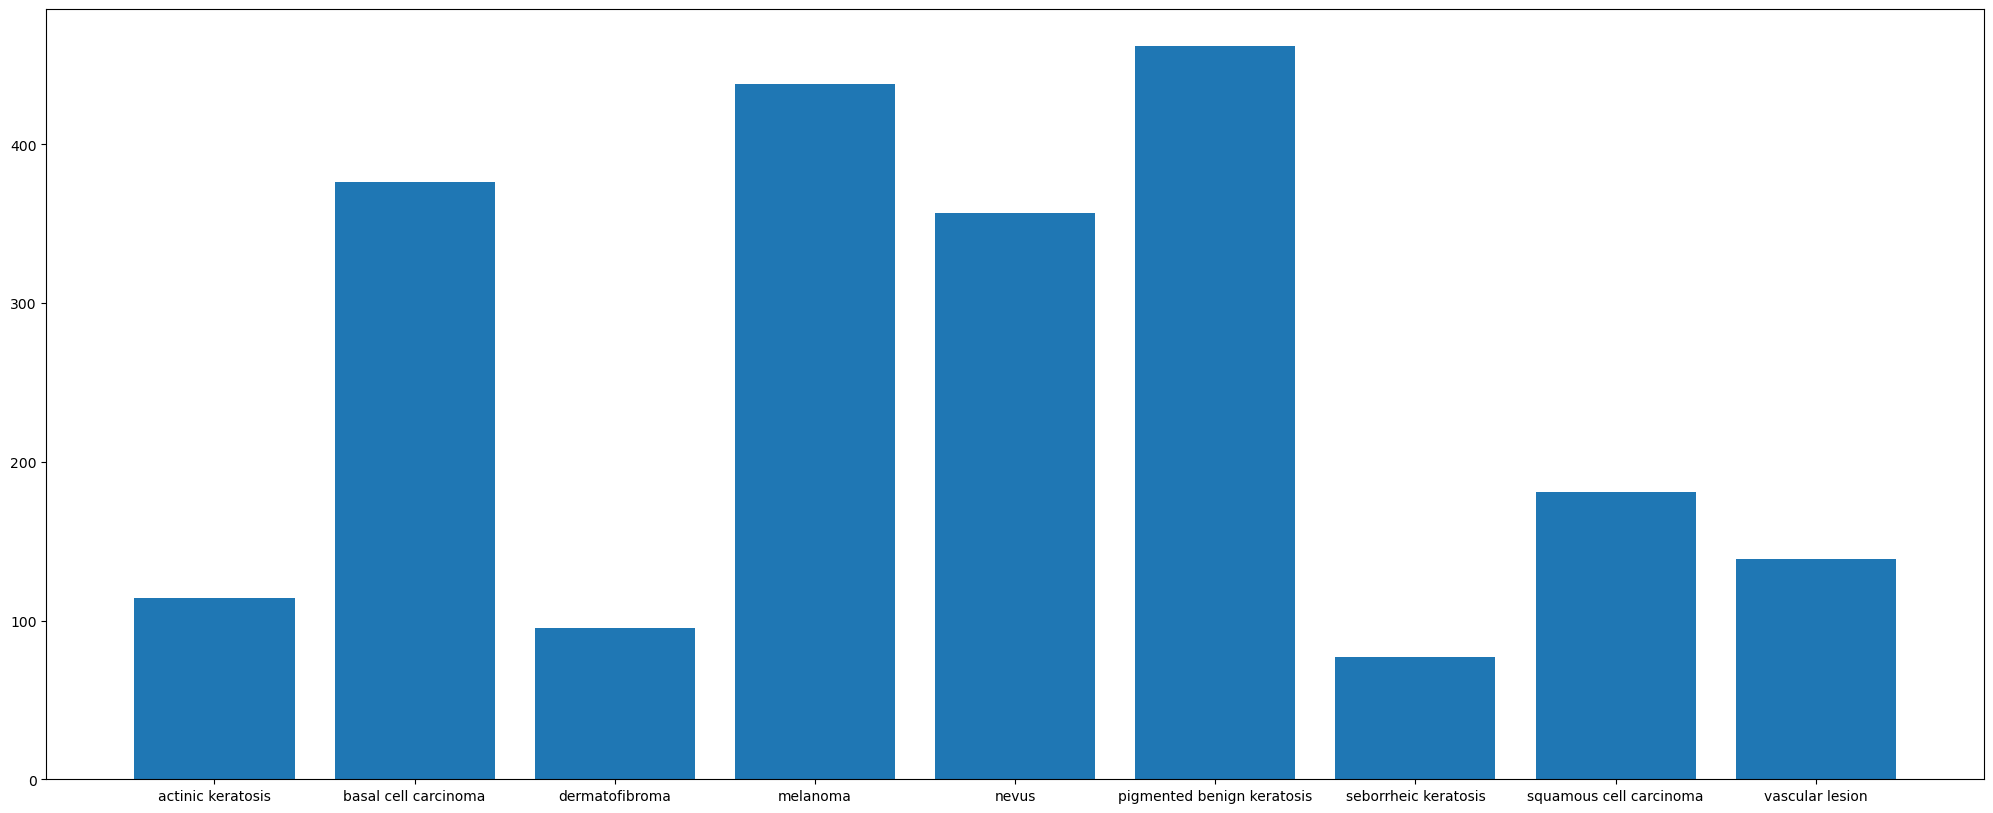

In [24]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### Answer-1 :- squamous cell carcinoma has least number of samples

#### Answer-2:- actinic keratosis and dermatofibroma have proportionate number of classes.
#### melanoma and pigmented benign keratosis have proprtionate number of classes

In [25]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
import Augmentor
for i in class_names:
    #p = Augmentor.Pipeline("{path_to_training_dataset} + {i}")
    p = Augmentor.Pipeline("Skin cancer ISIC The International Skin Imaging Collaboration/Train", save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCD2A51D340>: 100%|██████████| 500/500 [00:05<00:00, 99.93 Samples/s]                     


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCD282B1AF0>: 100%|██████████| 500/500 [00:05<00:00, 95.17 Samples/s]                     


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCD2A505490>: 100%|██████████| 500/500 [00:05<00:00, 90.76 Samples/s]                     


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=962x722 at 0x7FCD2828BF10>: 100%|██████████| 500/500 [00:06<00:00, 76.51 Samples/s]                     


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCD262A1070>: 100%|██████████| 500/500 [00:07<00:00, 71.05 Samples/s]   


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCEC94CAC10>: 100%|██████████| 500/500 [00:09<00:00, 54.10 Samples/s]                     


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCECA5498B0>: 100%|██████████| 500/500 [00:08<00:00, 59.09 Samples/s]   


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCD25D04940>: 100%|██████████| 500/500 [00:09<00:00, 53.69 Samples/s]                     


Initialised with 2239 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCD262962B0>: 100%|██████████| 500/500 [00:09<00:00, 50.36 Samples/s]                     


In [28]:
# To move files from output folder to each class folder
class_names
source_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/output'
target_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
for name in class_names:
    #print(name)
    new_source_dir = f'{source_dir}/{name}'
    new_target_dir = f'{target_dir}/{name}'
    file_names = os.listdir(f'{new_source_dir}')
    #print(file_names)
    for file_name in file_names:
        shutil.move(os.path.join(new_source_dir, file_name), new_target_dir)

shutil.rmtree(source_dir)

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
data_dir_train1 = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

6739


In [30]:
for i in class_names:
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
#new_df

### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
#print(os.path.join(data_dir_train,'output', '*.jpg'))
#path_list = [x for x in glob(os.path.join(data_dir_train,'output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029460.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0031993.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029500.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026626.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0032135.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029930.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027896.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0033413.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028190.jpg',
 'Skin cancer ISIC The International 

In [32]:
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list))

In [34]:
#df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
6734,Skin cancer ISIC The International Skin Imagin...,vascular lesion
6735,Skin cancer ISIC The International Skin Imagin...,vascular lesion
6736,Skin cancer ISIC The International Skin Imagin...,vascular lesion
6737,Skin cancer ISIC The International Skin Imagin...,vascular lesion


In [35]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1331
melanoma                      1313
nevus                         1136
basal cell carcinoma          1132
squamous cell carcinoma        528
vascular lesion                445
actinic keratosis              336
dermatofibroma                 280
seborrheic keratosis           238
Name: count, dtype: int64

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [39]:
## your code goes here
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [41]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 370s 2s/step - loss: 1.9840 - accuracy: 0.2478 - val_loss: 1.7525 - val_accuracy: 0.3653
Epoch 2/50
169/169 [==============================] - 400s 2s/step - loss: 1.5470 - accuracy: 0.4533 - val_loss: 1.5362 - val_accuracy: 0.4744
Epoch 3/50
169/169 [==============================] - 419s 2s/step - loss: 1.4545 - accuracy: 0.4863 - val_loss: 1.5698 - val_accuracy: 0.4625
Epoch 4/50
169/169 [==============================] - 428s 3s/step - loss: 1.3585 - accuracy: 0.5234 - val_loss: 1.3187 - val_accuracy: 0.5189
Epoch 5/50
169/169 [==============================] - 419s 2s/step - loss: 1.2349 - accuracy: 0.5625 - val_loss: 1.2348 - val_accuracy: 0.5590
Epoch 6/50
169/169 [==============================] - 463s 3s/step - loss: 1.1194 - accuracy: 0.5979 - val_loss: 1.2388 - val_accuracy: 0.5561
Epoch 7/50
169/169 [==============================] - 433s 3s/step - loss: 1.0639 - accuracy: 0.6139 - val_loss: 1.3396 - val_accuracy: 0.5345

#### **Todo:**  Visualize the model results

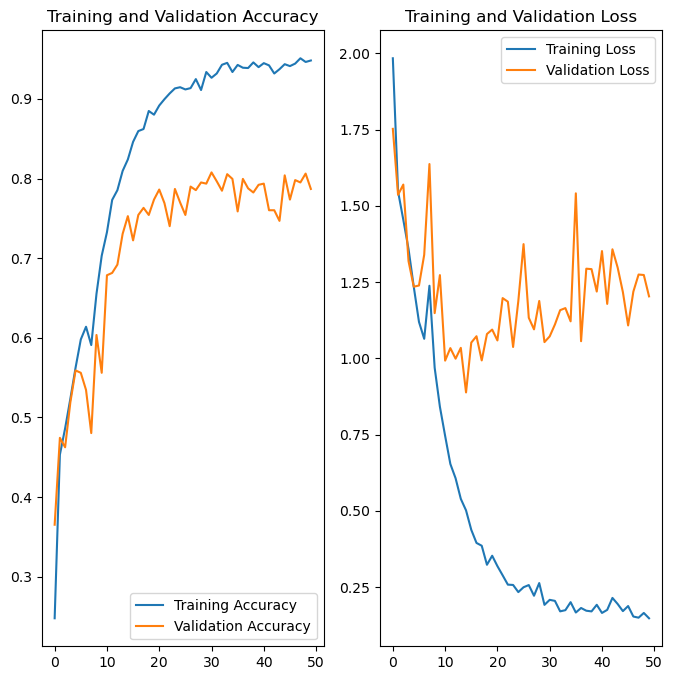

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter